In [1]:
import pickle

with open(r"C:\Users\jdeblander\LiveProjects\Image classification\train_test_val_array.pkl", "rb") as f:
    data = pickle.load(f)

In [2]:
import tensorflow as tf

print(tf.__version__)


2.5.0


In [3]:
# We need to know the number of steps per epochs this will be found with the batch size and the lenght of the dataset
from glob import glob

len_train = len(glob(r"C:\Users\jdeblander\LiveProjects\Image classification\Data\train\*\*.jpg"))

In [42]:
import numpy
height = 100
width = 100
batch_size = 32
steps_per_epoch = numpy.ceil(len_train / batch_size)

In [6]:
from pathlib import Path

train_data_dir = r"C:\Users\jdeblander\LiveProjects\Image classification\Data\train"
train_data_dir = Path(train_data_dir)

val_data_dir = r"C:\Users\jdeblander\LiveProjects\Image classification\Data\validation"
val_data_dir = Path(val_data_dir)

test_data_dir = r"C:\Users\jdeblander\LiveProjects\Image classification\Data\test"
test_data_dir = Path(test_data_dir)

In [7]:
train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

In [8]:
import os
class_names = numpy.array([item.name for item in train_data_dir.glob('*')])

def get_label(path):
    parts = tf.strings.split(path, os.path.sep)
    return parts[-2] == class_names[0]

In [25]:
class_names[0]

'swift'

In [9]:
def decode_img(img):

    img = tf.image.decode_jpeg(img, channels= 3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    return tf.image.resize(img, [height, width])

In [26]:
def process_path(file_path):

    label = get_label(file_path)

    img = tf.io.read_file(file_path)

    img = decode_img(img)

    return img, label

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_labeled_ds = train_list_ds.map(process_path, AUTOTUNE)

In [28]:
val_labeled_ds = val_list_ds.map(process_path, 
                                 num_parallel_calls=AUTOTUNE)

In [29]:
test_labeled_ds = test_list_ds.map(process_path, 
                                   num_parallel_calls=AUTOTUNE)

In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
      # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [16]:
def prepare_for_testing(ds, cache=True):
      # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [30]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[0] if label_batch[n]==True else class_names[1])
    #   plt.title(class_names[label_batch[n]==class_names[0]][0].title())
        plt.axis('off')

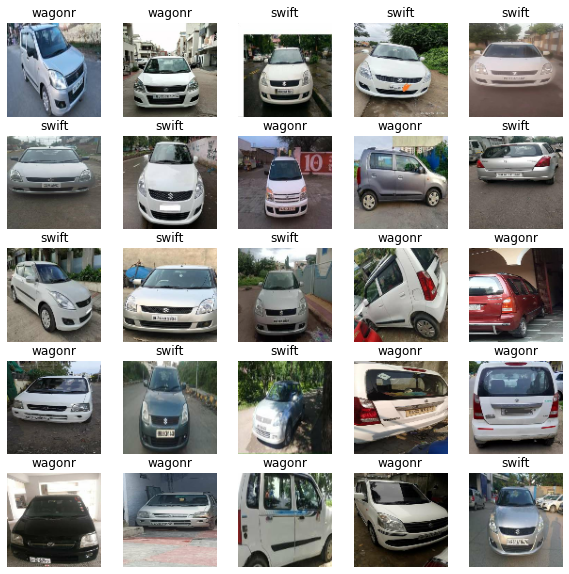

In [32]:
train_ds = prepare_for_training(train_labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

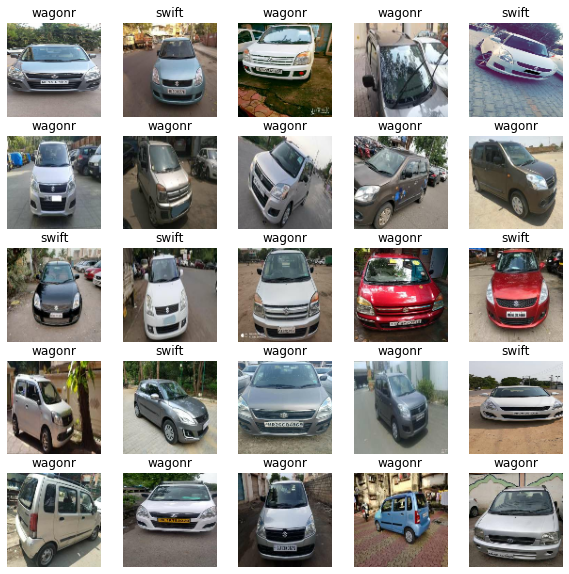

In [33]:
val_ds = prepare_for_testing(val_labeled_ds)

image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

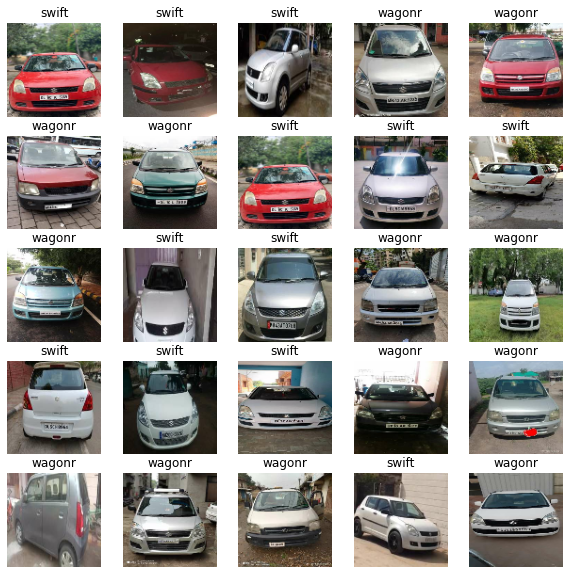

In [34]:
test_ds = prepare_for_testing(test_labeled_ds)

image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [35]:
import time
default_timeit_steps = 100

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batch_size*steps/duration))

In [36]:
input_shape = (100, 100, 3)
num_outputs = 1
num_epochs = 10

In [40]:
from tensorflow import keras
def get_model(input_shape, num_neurons, num_outputs):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(num_neurons, activation='relu'),
        keras.layers.Dense(num_outputs)
    ])
    
    return model

In [44]:
import numpy as np
num_neurons = 64
one_layer_64 = get_model(input_shape, num_neurons, num_outputs)
one_layer_64.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/one_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = one_layer_64.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = one_layer_64.evaluate(val_ds, verbose=2)
test_loss, test_acc = one_layer_64.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 2s 17ms/step - loss: 1.3942 - accuracy: 0.5487 - val_loss: 0.8001 - val_accuracy: 0.5525
Epoch 2/10
75/75 [==============================] - 1s 19ms/step - loss: 0.8512 - accuracy: 0.5871 - val_loss: 1.1743 - val_accuracy: 0.5188
Epoch 3/10
75/75 [==============================] - 2s 21ms/step - loss: 1.0019 - accuracy: 0.5625 - val_loss: 1.0828 - val_accuracy: 0.5412
Epoch 4/10
75/75 [==============================] - 1s 17ms/step - loss: 0.7590 - accuracy: 0.6421 - val_loss: 0.9297 - val_accuracy: 0.5437
Epoch 5/10
75/75 [==============================] - 1s 17ms/step - loss: 0.7863 - accuracy: 0.6446 - val_loss: 0.8678 - val_accuracy: 0.5600
Epoch 6/10
75/75 [==============================] - 1s 17ms/step - loss: 0.6827 - accuracy: 0.6683 - val_loss: 0.6758 - val_accuracy: 0.6263
Epoch 7/10
75/75 [==============================] - 2s 24ms/step - loss: 0.6473 - accuracy: 0.6771 - val_loss: 0.9787 - val_accuracy: 0.5600
Epoch 8/10
75

In [45]:
num_neurons = 128
one_layer_128 = get_model(input_shape, num_neurons, num_outputs)
one_layer_128.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/one_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = one_layer_128.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = one_layer_128.evaluate(val_ds, verbose=2)
test_loss, test_acc = one_layer_128.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 3s 32ms/step - loss: 1.6914 - accuracy: 0.5333 - val_loss: 1.0197 - val_accuracy: 0.5525
Epoch 2/10
75/75 [==============================] - 2s 32ms/step - loss: 1.0274 - accuracy: 0.5729 - val_loss: 0.9924 - val_accuracy: 0.5412
Epoch 3/10
75/75 [==============================] - 2s 29ms/step - loss: 0.8635 - accuracy: 0.6004 - val_loss: 0.9228 - val_accuracy: 0.5800
Epoch 4/10
75/75 [==============================] - 2s 24ms/step - loss: 0.9385 - accuracy: 0.6175 - val_loss: 0.7614 - val_accuracy: 0.5900
Epoch 5/10
75/75 [==============================] - 2s 28ms/step - loss: 0.7234 - accuracy: 0.6471 - val_loss: 0.7238 - val_accuracy: 0.5888
Epoch 6/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6510 - accuracy: 0.6708 - val_loss: 0.8235 - val_accuracy: 0.5938
Epoch 7/10
75/75 [==============================] - 2s 29ms/step - loss: 0.6584 - accuracy: 0.6758 - val_loss: 0.8119 - val_accuracy: 0.5575
Epoch 8/10
75

In [46]:
num_neurons = 256
one_layer_256 = get_model(input_shape, num_neurons, num_outputs)
one_layer_256.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/one_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = one_layer_256.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = one_layer_256.evaluate(val_ds, verbose=2)
test_loss, test_acc = one_layer_256.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 4s 48ms/step - loss: 2.7621 - accuracy: 0.5467 - val_loss: 0.6813 - val_accuracy: 0.5950
Epoch 2/10
75/75 [==============================] - 3s 46ms/step - loss: 0.8218 - accuracy: 0.5704 - val_loss: 1.8860 - val_accuracy: 0.5025
Epoch 3/10
75/75 [==============================] - 4s 53ms/step - loss: 1.1246 - accuracy: 0.5733 - val_loss: 0.7661 - val_accuracy: 0.5925
Epoch 4/10
75/75 [==============================] - 4s 51ms/step - loss: 0.8589 - accuracy: 0.5829 - val_loss: 1.2543 - val_accuracy: 0.5113
Epoch 5/10
75/75 [==============================] - 5s 63ms/step - loss: 0.6156 - accuracy: 0.6762 - val_loss: 0.7133 - val_accuracy: 0.5800
Epoch 6/10
75/75 [==============================] - 4s 52ms/step - loss: 0.6181 - accuracy: 0.6654 - val_loss: 0.8216 - val_accuracy: 0.5575
Epoch 7/10
75/75 [==============================] - 5s 60ms/step - loss: 0.6154 - accuracy: 0.6779 - val_loss: 0.6867 - val_accuracy: 0.5987
Epoch 8/10
75

In [47]:
!pip install -U tensorboard_plugin_profile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [48]:
num_neurons = 512
one_layer_512 = get_model(input_shape, num_neurons, num_outputs)
one_layer_512.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = f"logs/scalars/one_layer_{num_neurons}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq = 1,
                                                   profile_batch = '500,520')

training_history = one_layer_512.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

print(f"Average test loss: {np.average(training_history.history['loss'])}")
val_loss, val_acc = one_layer_512.evaluate(val_ds, verbose=2)
test_loss, test_acc = one_layer_512.evaluate(test_ds, verbose=2)

print(f"\nTest accuracy: {test_acc}")
print(f"\nValidation accuracy: {val_acc}")

Epoch 1/10
75/75 [==============================] - 7s 89ms/step - loss: 6.0804 - accuracy: 0.5308 - val_loss: 1.9819 - val_accuracy: 0.5150
Epoch 2/10
75/75 [==============================] - 7s 89ms/step - loss: 1.4380 - accuracy: 0.5754 - val_loss: 1.6570 - val_accuracy: 0.5350
Epoch 3/10
75/75 [==============================] - 7s 89ms/step - loss: 1.3701 - accuracy: 0.6146 - val_loss: 1.0344 - val_accuracy: 0.5550
Epoch 4/10
75/75 [==============================] - 7s 90ms/step - loss: 1.9101 - accuracy: 0.5692 - val_loss: 1.5359 - val_accuracy: 0.5938
Epoch 5/10
75/75 [==============================] - 6s 83ms/step - loss: 1.1551 - accuracy: 0.6375 - val_loss: 0.8186 - val_accuracy: 0.5800
Epoch 6/10
75/75 [==============================] - 7s 89ms/step - loss: 0.6117 - accuracy: 0.6925 - val_loss: 0.7703 - val_accuracy: 0.6000
Epoch 7/10
75/75 [==============================] - 7s 89ms/step - loss: 0.6725 - accuracy: 0.6833 - val_loss: 1.5876 - val_accuracy: 0.5075
Epoch 8/10
75